In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import os
import re
from pyproj import Transformer
from scipy.spatial import cKDTree
from sklearn.metrics import r2_score, mean_squared_error
from grafi import (
    display_error_tables,
    display_winddir_met,
    display_cosine,
    plot_metric_res_2,
    plot_metric_res,
    plot_wind_speed_comparison,
    plot_week_comparison_with_dates,
    plot_wind_direction_comparison_bezigrad,
    plot_wind_speed_error_by_hour_multistation,
    plot_wind_speed_error_by_month_all_stations,
    plot_wind_errors_all_stations,
    plot_wdir_error_by_wspeed_all_stations
)

In [2]:
base_path = "C:\\Users\\alex\\Desktop\\veter_data"

if not os.path.exists(base_path):
    print(f"{base_path} ne obstaja")

def prepare_data(filepath, start_year=2021, freq='h'):
    start_date = f"{start_year}-01-01"

    df = pd.read_csv(filepath, header=1)

    df = df.drop(columns=['AKLA4'], errors='ignore')

    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.date_range(start=start_date, periods=len(df), freq=freq)

    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

    # for col in df.columns:
    #     if pd.api.types.is_numeric_dtype(df[col]):
    #         mean = df[col].mean()
    #         std = df[col].std()
    #         df[col] = df[col].clip(upper=mean + 4*std)
            
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour

    return df

In [3]:
# meteopgt2021.all
file_2021 = os.path.join(base_path, 'meteopgt2021.all')
df_2021 = prepare_data(file_2021, 2021)

# meteopgt2023.all
file_2023 = os.path.join(base_path, 'meteopgt2023.all')
df_2023 = prepare_data(file_2023, 2023)

In [4]:
df_2021.describe()

,bezigrad_WDir,bezigrad_WSpeed,bezigrad_T2m,bezigrad_RH,borst_WDir,borst_WSpeed,borst_T2m,borst_RH,let_lj_WDir,let_lj_WSpeed,...,pasja_WSpeed,pasja_T2m,pasja_RH,vrhnika_WDir,vrhnika_WSpeed,vrhnika_T2m,vrhnika_RH,month,day,hour
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,14.376096,1.257295,11.408116,72.645856,17.019406,1.439709,9.343116,78.815183,20.140537,1.543447,...,1.626655,7.624817,78.889041,18.294509,1.702221,10.597466,76.428082,6.526027,15.720548,11.500000
std,12.180134,1.135225,8.965390,19.582606,9.371792,8.815571,8.453019,19.699286,9.481655,1.267067,...,0.697954,8.174766,18.431615,10.665306,3.613370,8.723675,19.244596,3.448048,8.796749,6.922582
min,0.000000,0.000000,-7.400000,17.600000,0.100000,0.080000,-10.700000,15.000000,0.100000,0.000000,...,0.220000,-13.500000,17.000000,0.100000,0.170000,-8.900000,19.000000,1.000000,1.000000,0.000000
25%,3.300000,0.400000,4.000000,58.300000,8.400000,0.500000,2.600000,65.000000,11.600000,0.700000,...,1.150000,1.300000,65.000000,8.000000,0.860000,3.775000,63.000000,4.000000,8.000000,5.750000
50%,10.600000,0.900000,10.300000,77.300000,18.800000,0.850000,8.500000,84.000000,22.300000,1.200000,...,1.510000,6.600000,82.000000,21.900000,1.430000,9.700000,81.000000,7.000000,16.000000,11.500000
75%,24.500000,1.800000,18.300000,89.800000,23.600000,1.730000,15.625000,97.000000,28.600000,2.100000,...,1.980000,14.200000,96.000000,25.100000,2.280000,17.100000,94.000000,10.000000,23.000000,17.250000
max,36.000000,7.500000,35.500000,99.000000,36.000000,626.270000,32.100000,102.000000,36.000000,11.100000,...,6.990000,29.400000,102.000000,36.000000,326.710000,34.300000,102.000000,12.000000,31.000000,23.000000


In [5]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [6]:
ss = {
    "bezigrad": (462285, 5101441),
    "borst": (436753, 5103859),
    "let_lj": (459769, 5117666),
    "pasja": (440342, 5105220),
    "vrhnika": (443571, 5090529),
}

transformer = Transformer.from_crs("EPSG:3794", "EPSG:4326", always_xy=True)
easting = 440325  
northing = 106750  
lon, lat = transformer.transform(easting, northing)

to_utm33 = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)
utm_e, utm_n = to_utm33.transform(lon, lat)

to_utm33 = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)
to_wgs84 = Transformer.from_crs("EPSG:4326", "EPSG:3794", always_xy=True)

for name, (easting, northing) in ss.items():
    lon, lat = to_utm33.transform(easting, northing)
    
    utm_e, utm_n = to_wgs84.transform(lon, lat)
    
    print("{:<10} {:<15,.0f} {:<15,.0f} {:<15.6f} {:<15.6f} ({:.0f}, {:.0f})".format(
        name, easting, northing, lat, lon, utm_e, utm_n))

bezigrad   462,285         5,101,441       46.065503       14.512353       (462274, 102972)
borst      436,753         5,103,859       46.085379       14.181936       (436734, 105391)
let_lj     459,769         5,117,666       46.211381       14.478447       (459757, 119202)
pasja      440,342         5,105,220       46.097950       14.228183       (440324, 106752)
vrhnika    443,571         5,090,529       45.966012       14.271693       (443554, 92057)


In [7]:
basepath = os.path.join(base_path, "VeterPodatkiARSO", "WND_ASCII")

info = {}
for filename in os.listdir(basepath):
    with open(os.path.join(basepath, filename), 'r') as f:
        for _ in range(6):
            line = f.readline().strip()
            key, value = line.split()
            info[key.lower()] = int(value)
        break
print(info)

{'ncols': 236, 'nrows': 200, 'xllcorner': 424000, 'yllcorner': 5078000, 'cellsize': 250, 'nodata_value': -9999}


In [8]:
def read_ascii(filepath):
    data = []

    with open(filepath, 'r') as f:
        for _ in range(6):
            line = f.readline().strip()

        for line in f:
            data.extend([float(x) for x in line.strip().split(',') if x])

    ncols = info.get('ncols')
    nrows = info.get('nrows')

    if ncols and nrows and len(data) == ncols * nrows:
        data_array = np.array(data).reshape(nrows, ncols)
    else:
        data_array = np.array(data)

    return data_array

def calculate_wind_parameters(u_data, v_data):
    wind_speed = np.sqrt(u_data**2 + v_data**2)
    wind_direction_deg = (((270 - np.degrees(np.arctan2(v_data, u_data))) % 360) / 10 )

    return wind_speed, wind_direction_deg

def process_wind(directory_path):
    u_list = []
    v_list = []
    time_indices = []
    time_to_prefix = {}

    file_groups = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.u') or filename.endswith('.v'):
            name = filename.split('.')[0]
            if name not in file_groups:
                file_groups[name] = {}
            file_groups[name][filename[-1]] = os.path.join(directory_path, filename)

    for prefix, files in file_groups.items():
        match = re.search(r'_(\d+)', prefix)
        if not match:
            continue
        hour = int(match.group(1))

        u_data = read_ascii(files.get('u'))
        v_data = read_ascii(files.get('v'))

        u_list.append(u_data)
        v_list.append(v_data)
        time_indices.append(hour)
        time_to_prefix[hour] = prefix

        # if hour % 100 == 0:
            # print(f"proc {prefix}")

    sorted_indices = np.argsort(time_indices)

    u_3d          = np.stack([u_list[i] for i in sorted_indices], axis=-1)
    v_3d          = np.stack([v_list[i] for i in sorted_indices], axis=-1)
    sorted_hours  = [time_indices[i] for i in sorted_indices]

    return u_3d, v_3d, sorted_hours, time_to_prefix

In [9]:
if not os.path.exists(basepath):
    print(f"{basepath}' ne obstja")

u, v, hours, time_prefixes = process_wind(basepath)

print(u.shape, v.shape, len(hours), len(time_prefixes))

(200, 236, 8760) (200, 236, 8760) 8760 8760


In [10]:
def get_final_uv(
    station_coords,
    u,
    v,
    grid_info,
    method='nearest',
    idw_radius=350,
    idw_power=2
):
    nrows, ncols = grid_info['nrows'], grid_info['ncols']
    xllcorner, yllcorner, cellsize = grid_info['xllcorner'], grid_info['yllcorner'], grid_info['cellsize']
    time_len = u.shape[2]
    
    x, y = station_coords
    uu = np.zeros(time_len)
    vv = np.zeros(time_len)
    
    if method == 'nearest':
        gy = int(round((y - yllcorner) / cellsize))
        gx = int(round((x - xllcorner) / cellsize))
        uu = u[gy, gx, :]
        vv = v[gy, gx, :]
        print(f"nearest y {gy} x {gx}")
    
    elif method == 'bilinear':
        fx = (x - xllcorner) / cellsize
        fy = (y - yllcorner) / cellsize
        x0, y0 = int(np.floor(fx)), int(np.floor(fy))
        dx = fx - x0
        dy = fy - y0
        x1 = min(x0 + 1, ncols - 1)
        y1 = min(y0 + 1, nrows - 1)
        print(y0,x0)

        for t in range(time_len):
            u_y0 = u[y0, x0, t] * (1 - dx) + u[y0, x1, t] * dx
            u_y1 = u[y1, x0, t] * (1 - dx) + u[y1, x1, t] * dx
            uu[t] = u_y0 * (1 - dy) + u_y1 * dy   

            v_y0 = v[y0, x0, t] * (1 - dx) + v[y0, x1, t] * dx
            v_y1 = v[y1, x0, t] * (1 - dx) + v[y1, x1, t] * dx
            vv[t] = v_y0 * (1 - dy) + v_y1 * dy

    elif method == 'radius':
        x_coords = np.arange(ncols) * cellsize + xllcorner
        y_coords = np.arange(nrows) * cellsize + yllcorner
        xx, yy = np.meshgrid(x_coords, y_coords)
        grid_points = np.column_stack((xx.reshape(-1), yy.reshape(-1)))
        tree = cKDTree(grid_points)
        
        indices = tree.query_ball_point([x, y], idw_radius)
        if not indices:
            raise ValueError(f"No points in radius {idw_radius}")
        
        pts = grid_points[indices]
        dists = np.linalg.norm(pts - np.array([x, y]), axis=1)
        weights = 1 / (dists**idw_power)
        weights /= np.sum(weights)

        for t in range(time_len):
            u_reshaped = u.reshape(-1, time_len)
            v_reshaped = v.reshape(-1, time_len)
            u_vals = np.array([u_reshaped[i, t] for i in indices])
            v_vals = np.array([v_reshaped[i, t] for i in indices])
            uu[t] = np.sum(weights * u_vals)
            vv[t] = np.sum(weights * v_vals)

    return uu, vv

class Station:
    u = None
    v = None
    def __init__(self, name, coords, u_final, v_final, speed, direction):
        self.name = name
        self.coords = coords
        self.u_final = u_final
        self.v_final = v_final
        self.speed = speed
        self.direction = direction

stations = {
    "bezigrad": (462285, 5101441),
    "borst": (436753, 5103859),
    "let_lj": (459769, 5117666),
    "pasja": (440342, 5105220),
    "vrhnika": (443571, 5090529),
}
names = {
    "bezigrad": "Bežigrad",
    "borst": "Boršt",
    "let_lj": "letališče", 
    "pasja": "Pasja ravan",
    "vrhnika": "Vrhnika"
}

Station.u = u
Station.v = v 
for i, (s, coords) in enumerate(stations.items()):
    u_bi, v_bi = get_final_uv(coords, u, v, info, method="bilinear")
    u_final, v_final = u_bi, v_bi
    
    spd, dir = calculate_wind_parameters(u_final, v_final)
    stations[s] = Station(s, coords, u_final, v_final, spd, dir)


93 153
103 51
158 143
108 65
50 78


In [11]:
def add_uv(df, station_name, dir_col="station_WDir", speed_col="station_WSpeed", out_u="station_u", out_v="station_v"):
    direction_deg = df[station_name + "_WDir"] * 10.0

    direction_rad = np.radians(direction_deg)

    df[station_name + "_u"] = -df[station_name + "_WSpeed"] * np.sin(direction_rad)
    df[station_name + "_v"] = -df[station_name + "_WSpeed"] * np.cos(direction_rad)
    return df

def finalize_df(df, stations):
    for s in stations:
        df = add_uv(df, s)
        df[s + "_u_model"] = stations[s].u_final
        df[s + "_v_model"] = stations[s].v_final
        df[s + "_WDir_model"] = stations[s].direction
        df[s + "_WSpeed_model"] = stations[s].speed
    
    return df[sorted(df.columns)]

df_2021 = finalize_df(df_2021, stations)
df_2023 = finalize_df(df_2023, stations)

In [12]:
def evaluate_model(stations, df):
    res = []
    
    for station in stations:
        station_results = []
        
        u_obs = df[f"{station}_u"].to_numpy()
        v_obs = df[f"{station}_v"].to_numpy()
        u_mod = df[f"{station}_u_model"].to_numpy()
        v_mod = df[f"{station}_v_model"].to_numpy()
        
        obs_vectors = np.stack([u_obs, v_obs], axis=1)
        mod_vectors = np.stack([u_mod, v_mod], axis=1)
        
        dot = np.sum(obs_vectors * mod_vectors, axis=1)
        norm_obs = np.linalg.norm(obs_vectors, axis=1)
        norm_mod = np.linalg.norm(mod_vectors, axis=1)
        cosine_sim = dot / (norm_obs * norm_mod + 1e-8)
        mean_cos_sim = np.mean(cosine_sim)

        for component in ["u", "v", "WSpeed", "WDir"]:
            obs_col = f"{station}_{component}"
            mod_col = f"{station}_{component}_model"
            obs = df[obs_col].to_numpy()
            mod = df[mod_col].to_numpy()
            
            is_dir = (component == "WDir")
            if is_dir:
                obs = obs * 10
                mod = mod * 10
                delta = (mod - obs + 180) % 360 - 180
                error = delta
            else:
                error = mod - obs

            abs_error = np.abs(error)
            sq_error = error**2
            rmse = np.sqrt(np.mean(sq_error))
            mae = np.mean(abs_error)
            bias = np.mean(error)
            R2 = r2_score(obs, mod)

            result = {
                'Name': f"{station}_{component}",
                'MAE': round(mae, 4),
                'RMSE': round(rmse, 4) if not is_dir else None,
                'MAPE': None,
                'Cosine': round(mean_cos_sim, 4) if component in ["u", "v"] else None,
                'R2': round(R2, 4) if not is_dir else None,
                'Bias': round(bias, 4),
            }

            if not is_dir:
                nonzero_obs = obs > 0.3
                mape_errors = np.abs(error[nonzero_obs] / obs[nonzero_obs]) * 100
                mape = np.mean(mape_errors)
                result['MAPE'] = round(mape, 2)

            station_results.append(result)
        
        res.extend(station_results)
        
    # SKUPN
    for component in ["u", "v", "WSpeed", "WDir"]:
        obs_all = []
        mod_all = []
        
        for station in stations:
            obs_col = f"{station}_{component}"
            mod_col = f"{station}_{component}_model"
            obs_all.append(df[obs_col].to_numpy())
            mod_all.append(df[mod_col].to_numpy())
        
        obs_all = np.concatenate(obs_all)
        mod_all = np.concatenate(mod_all)
        
        if component in ["u", "v"]:
            u_obs_all = np.concatenate([df[f"{station}_u"].to_numpy() for station in stations])
            v_obs_all = np.concatenate([df[f"{station}_v"].to_numpy() for station in stations])
            u_mod_all = np.concatenate([df[f"{station}_u_model"].to_numpy() for station in stations])
            v_mod_all = np.concatenate([df[f"{station}_v_model"].to_numpy() for station in stations])
            
            obs_vectors_all = np.stack([u_obs_all, v_obs_all], axis=1)
            mod_vectors_all = np.stack([u_mod_all, v_mod_all], axis=1)
            
            dot_all = np.sum(obs_vectors_all * mod_vectors_all, axis=1)
            norm_obs_all = np.linalg.norm(obs_vectors_all, axis=1)
            norm_mod_all = np.linalg.norm(mod_vectors_all, axis=1)
            cosine_sim_all = dot_all / (norm_obs_all * norm_mod_all + 1e-8)
            mean_cos_sim_all = np.mean(cosine_sim_all)
            
        is_dir = (component == "WDir")
        if is_dir:
            obs_all = obs_all * 10
            mod_all = mod_all * 10
            delta = (mod_all - obs_all + 180) % 360 - 180
            error = delta
        else:
            error = mod_all - obs_all

        abs_error = np.abs(error)
        sq_error = error**2
        rmse = np.sqrt(np.mean(sq_error))
        mae = np.mean(abs_error)
        bias = np.mean(error)
        ss_tot = np.sum((obs_all - np.mean(obs_all))**2)
        ss_res = np.sum((obs_all - mod_all)**2)
        R2 = 1 - (ss_res / ss_tot)

        result = {
            'Name': f"total_{component}",
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4) if not is_dir else None,
            'MAPE': None,
            'Cosine': round(mean_cos_sim_all, 4) if component in ["u", "v"] else None,
            'R2': round(R2, 4) if not is_dir else None,
            'Bias': round(bias, 4),
        }

        if not is_dir:
            nonzero_obs = obs_all > 0.3
            mape_errors = np.abs(error[nonzero_obs] / obs_all[nonzero_obs]) * 100
            mape = np.mean(mape_errors)
            result['MAPE'] = round(mape, 2)

        res.append(result)
    
    return pd.DataFrame(res)

results_2021 = evaluate_model(stations, df_2021)
print(results_2021)

               Name      MAE    RMSE    MAPE  Cosine      R2     Bias
0        bezigrad_u   0.3691  0.5886   37.33  0.6901  0.7895   0.0967
1        bezigrad_v   0.3244  0.4639   31.06  0.6901  0.8241   0.1108
2   bezigrad_WSpeed   0.3931  0.6335   31.34     NaN  0.6886  -0.2233
3     bezigrad_WDir  35.9436     NaN     NaN     NaN     NaN -11.7312
4           borst_u   0.5949  6.8740   68.59  0.6228  0.2405  -0.0049
5           borst_v   0.4778  3.3973   51.85  0.6228  0.3406  -0.0438
6      borst_WSpeed   0.5930  7.6440   41.47     NaN  0.2480  -0.3892
7        borst_WDir  41.9020     NaN     NaN     NaN     NaN   1.9515
8          let_lj_u   1.1697  1.6714  130.38  0.2216 -0.0236  -0.5860
9          let_lj_v   0.8484  1.1470   93.22  0.2216 -0.0880   0.1384
10    let_lj_WSpeed   0.8866  1.4094   62.83     NaN -0.2375  -0.3493
11      let_lj_WDir  73.7262     NaN     NaN     NaN     NaN  -5.2329
12          pasja_u   0.7245  1.1373   51.26  0.7115  0.3338   0.2257
13          pasja_v 

In [13]:
results_2023 = evaluate_model(stations, df_2023)
print(results_2023)

               Name      MAE    RMSE    MAPE  Cosine      R2     Bias
0        bezigrad_u   1.1000  1.5675  117.58  0.1137 -0.4444   0.1453
1        bezigrad_v   0.9106  1.3103  113.24  0.1137 -0.5077   0.1024
2   bezigrad_WSpeed   0.9157  1.3192   71.59     NaN -0.3209  -0.2010
3     bezigrad_WDir  80.6323     NaN     NaN     NaN     NaN  -5.0916
4           borst_u   1.2470  7.4660  135.65  0.0594 -0.0360  -0.0134
5           borst_v   1.0530  4.7780  107.68  0.0594 -0.0487   0.0154
6      borst_WSpeed   0.9870  8.6542   73.06     NaN -0.0191  -0.4057
7        borst_WDir  85.6009     NaN     NaN     NaN     NaN  -3.0919
8          let_lj_u   1.4824  2.0717  150.43  0.0147 -0.4817  -0.5453
9          let_lj_v   0.9941  1.3757  103.97  0.0147 -0.3445   0.1810
10    let_lj_WSpeed   0.9967  1.5677   67.08     NaN -0.4197  -0.4184
11      let_lj_WDir  88.8315     NaN     NaN     NaN     NaN  -3.0069
12          pasja_u   1.3244  1.7893  105.77  0.1206 -0.4979   0.2867
13          pasja_v 

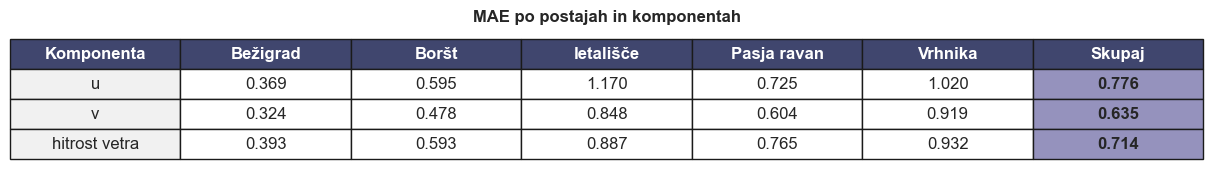

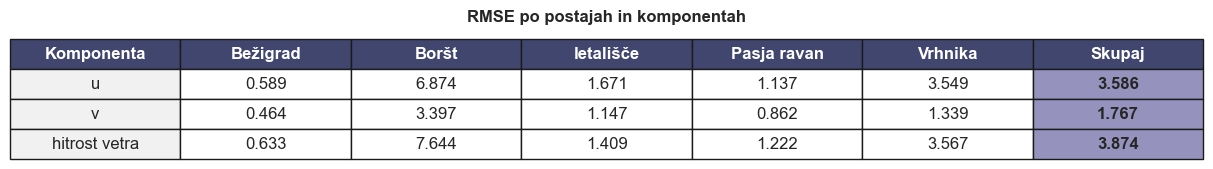

In [14]:
display_error_tables(results_2021, stations, n=names)

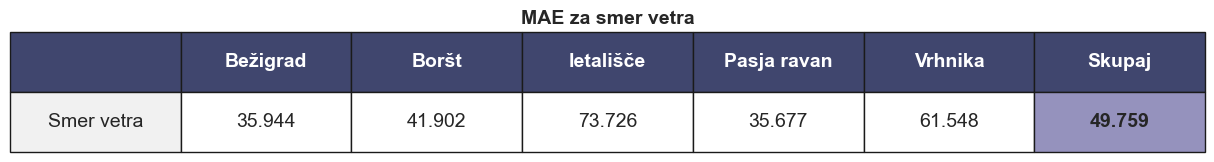

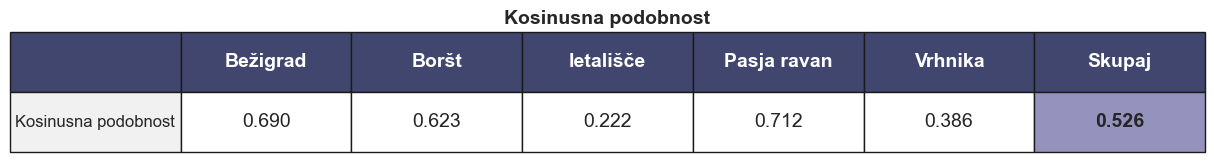

In [15]:
display_winddir_met(results_2021, stations, names)
display_cosine(results_2021, stations, names)

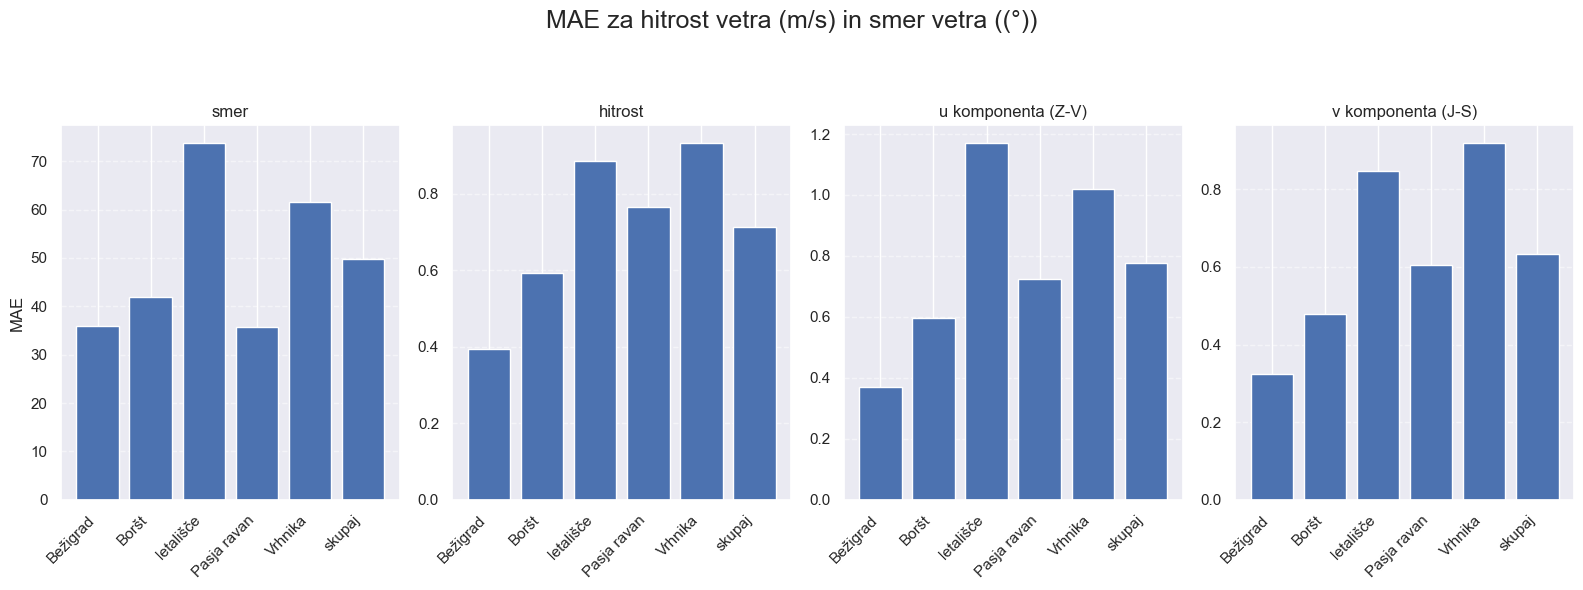

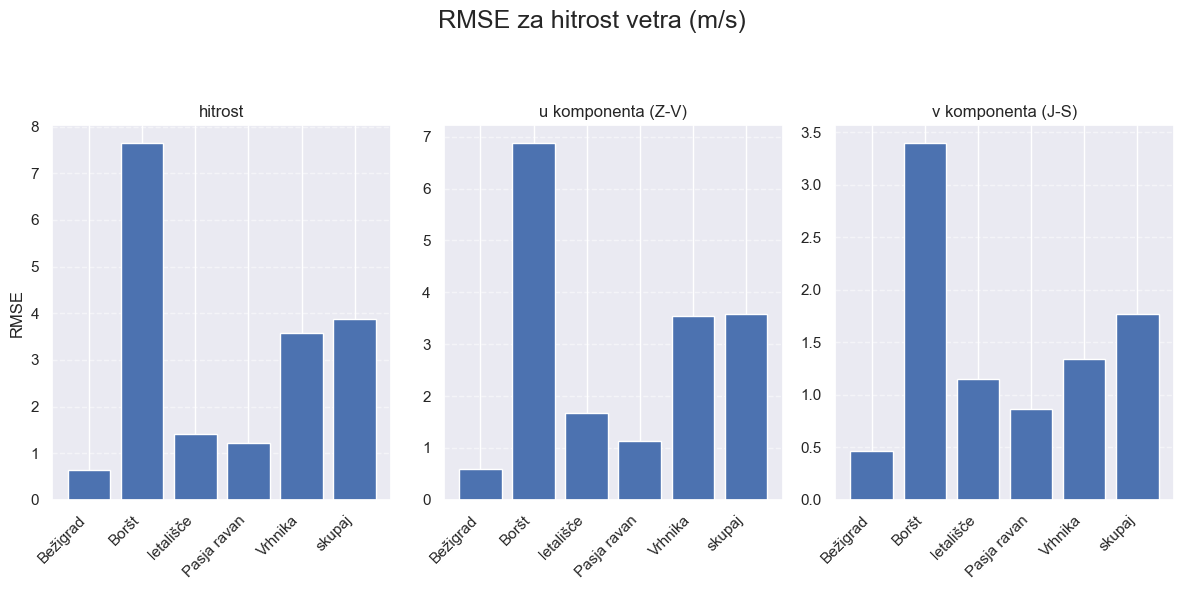

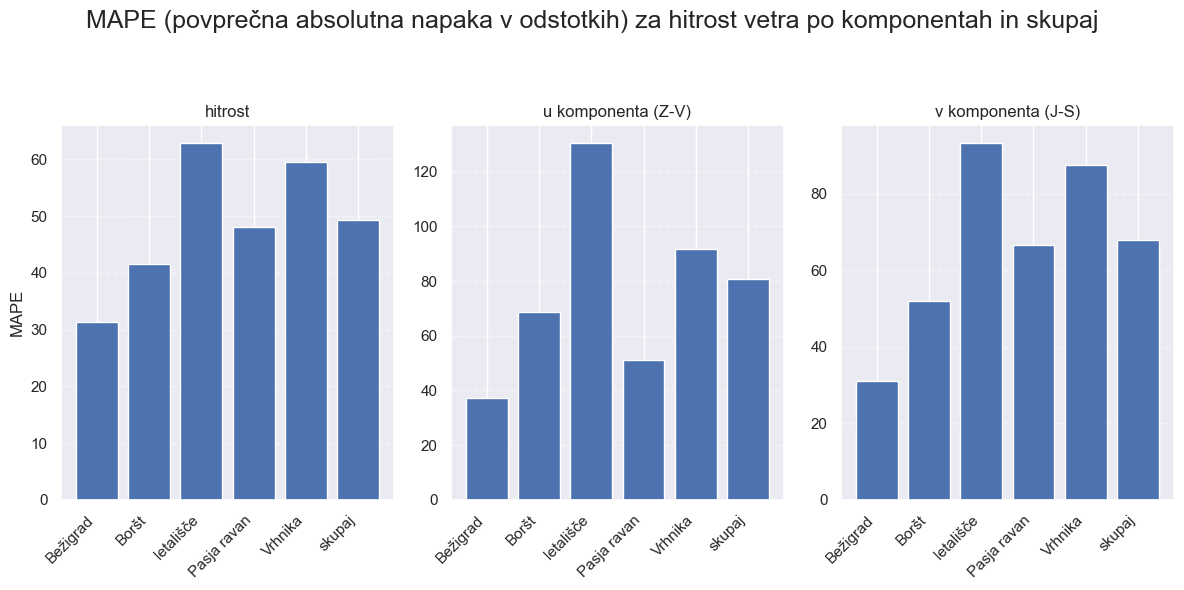

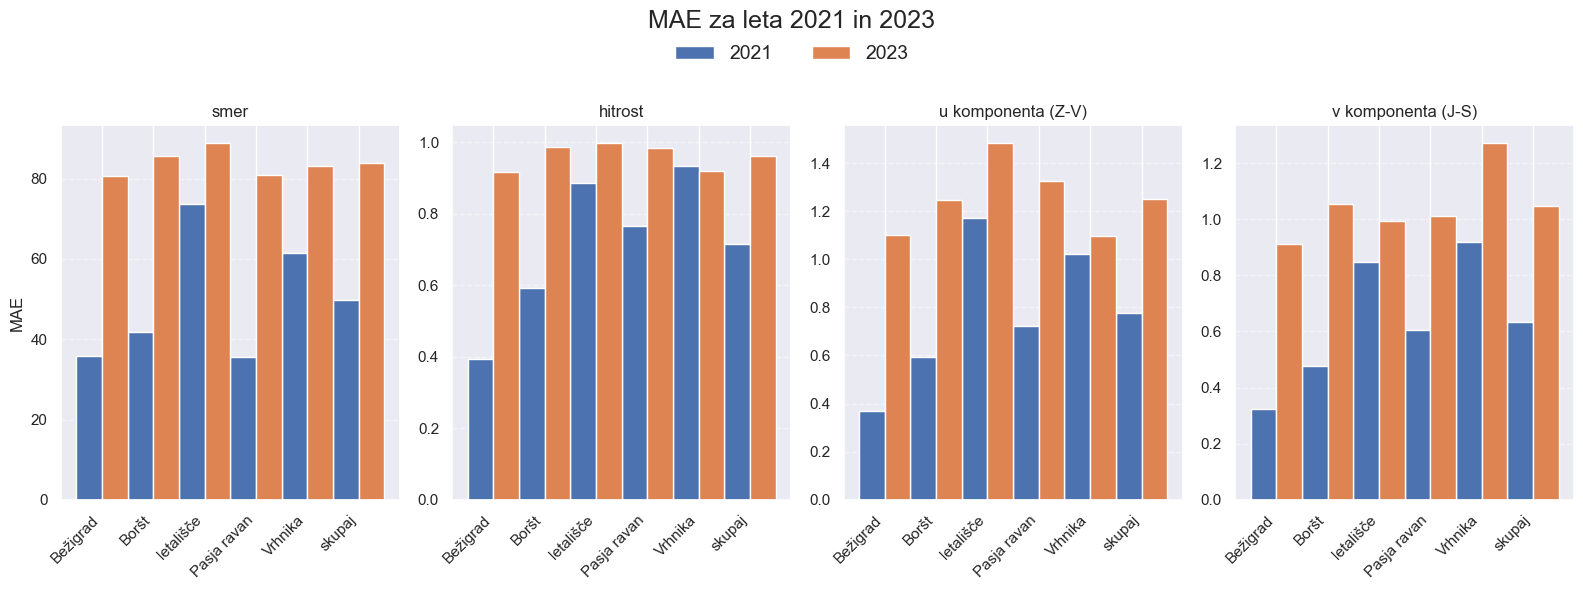

In [16]:
plot_metric_res(
    metric='MAE',
    df1=results_2021,
    names=names,
    title='MAE za hitrost vetra (m/s) in smer vetra ((°))'
)

plot_metric_res(
    metric='RMSE',
    df1=results_2021,
    names=names,
    title='RMSE za hitrost vetra (m/s)',
    ign=["WDir"]
)

plot_metric_res(
    metric='MAPE',
    df1=results_2021,
    names=names,
    title='MAPE (povprečna absolutna napaka v odstotkih) za hitrost vetra po komponentah in skupaj',
    ign=["WDir"]
)

plot_metric_res_2(
    metric='MAE',
    df1=results_2021,
    df2=results_2023,
    names=names,
    title='MAE za leta 2021 in 2023'
)

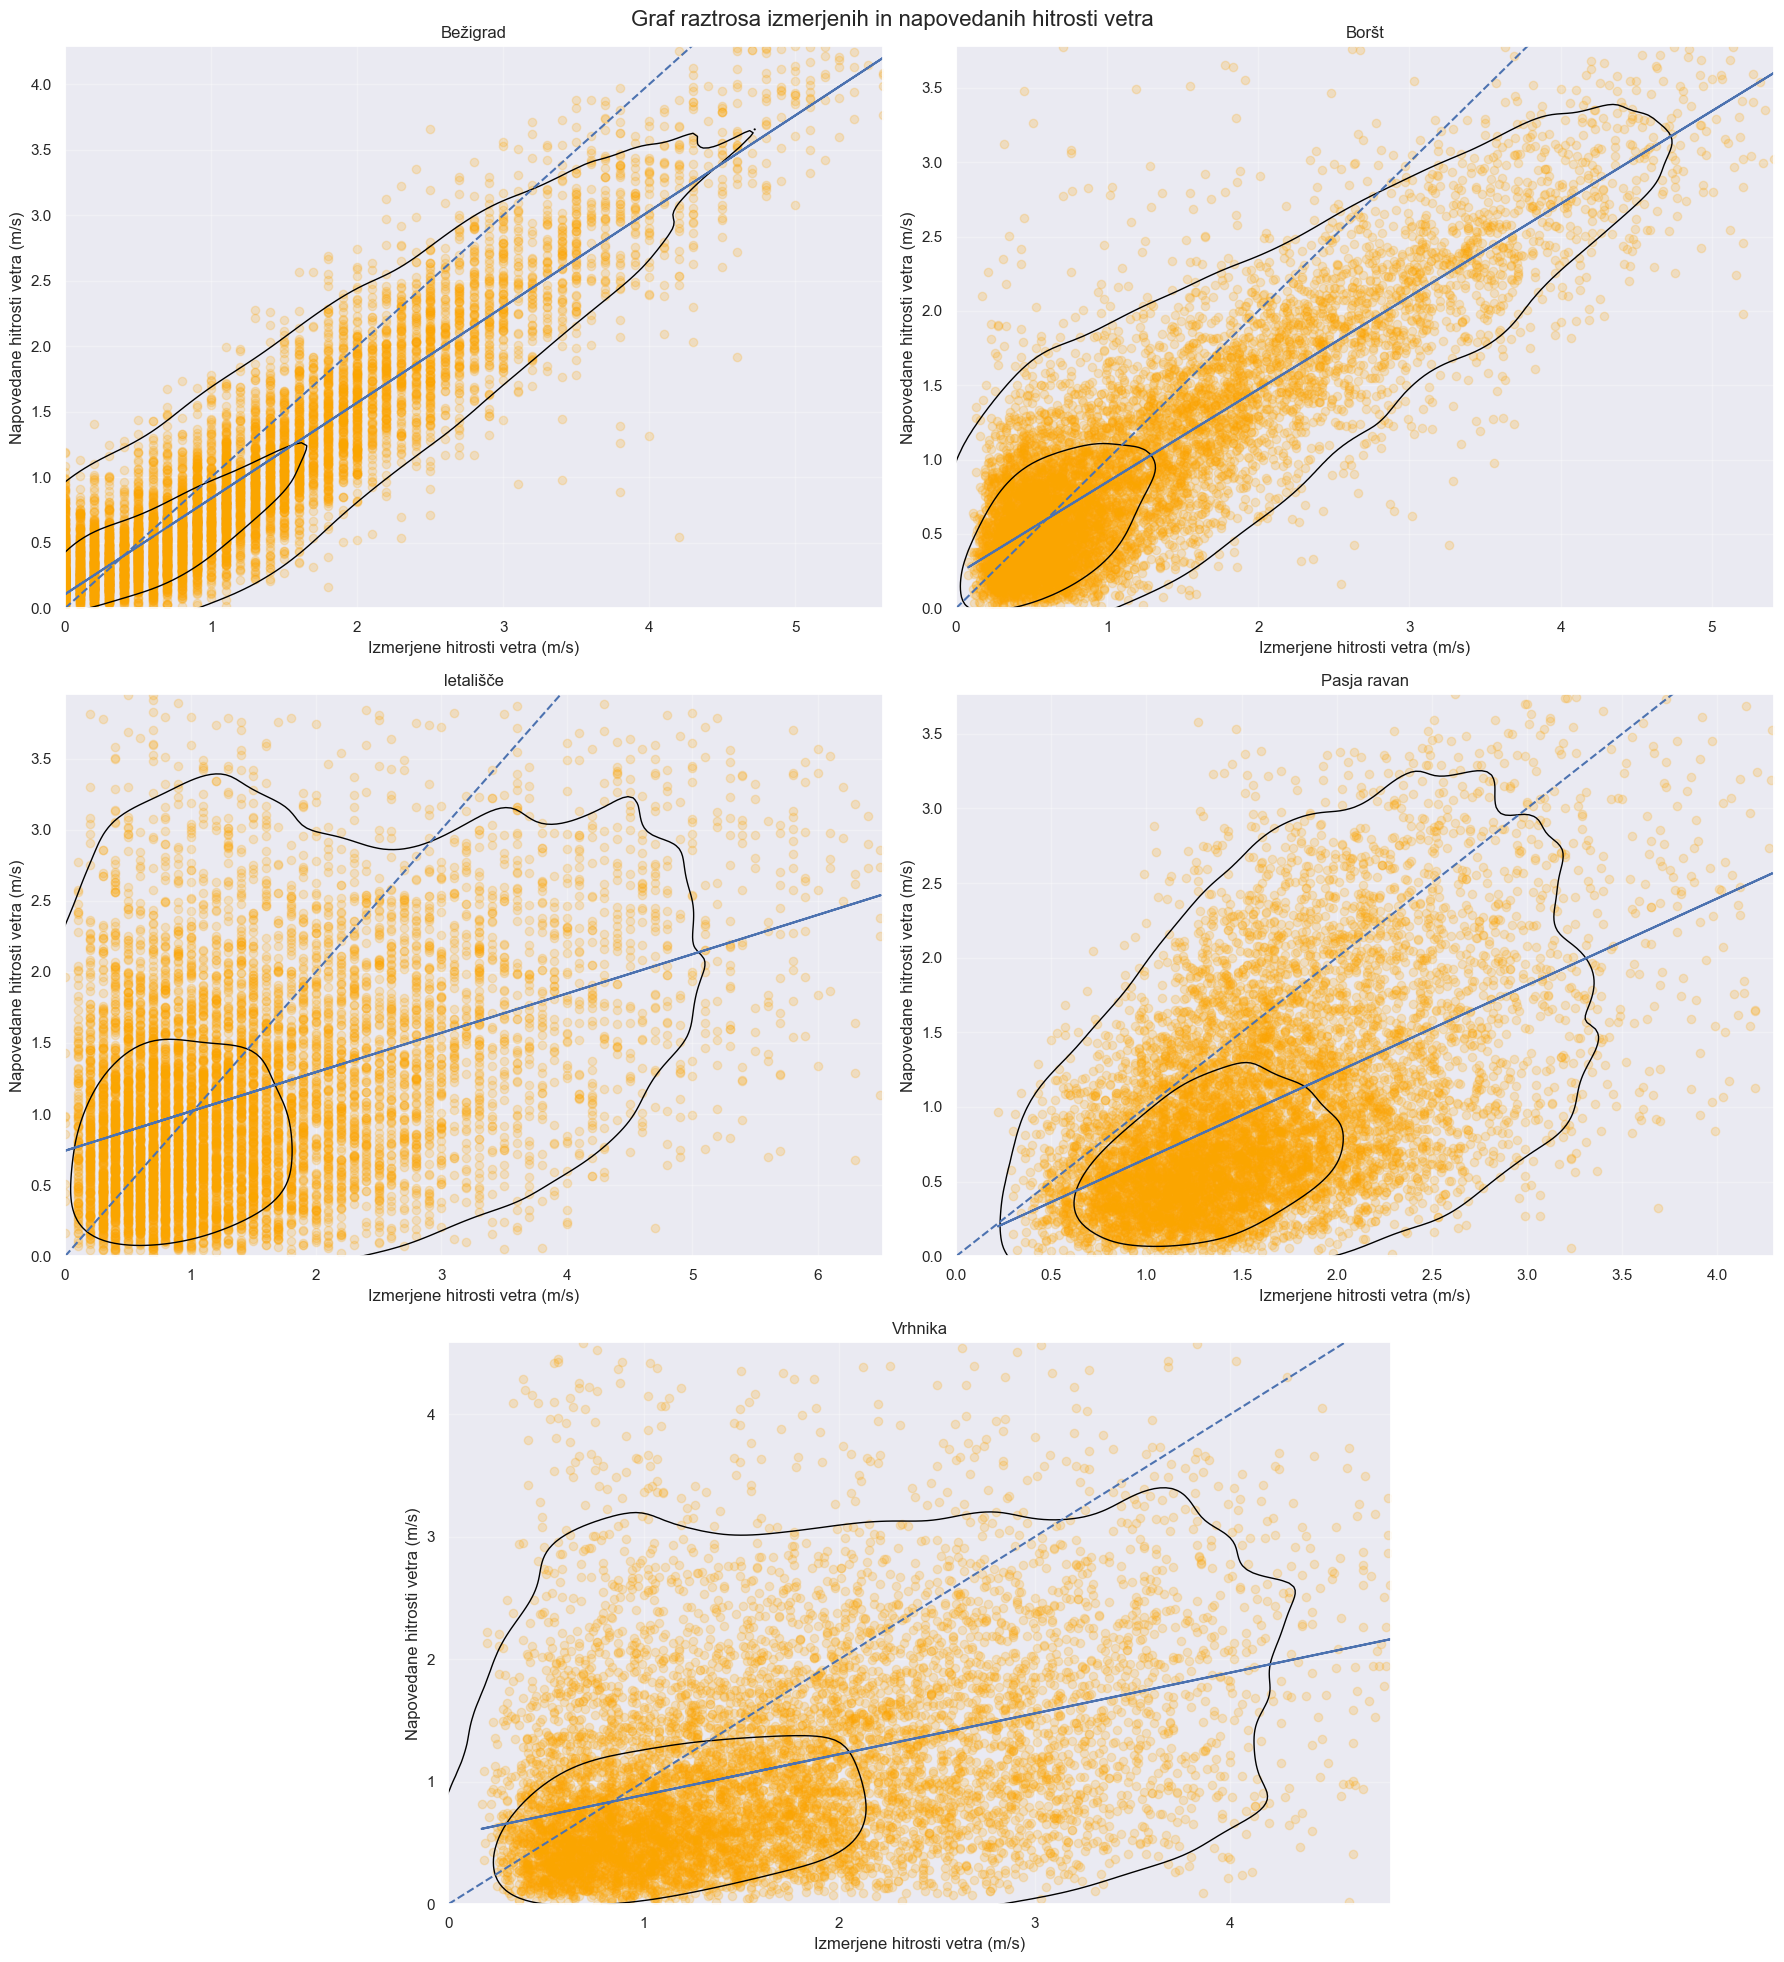

In [17]:
plot_wind_speed_comparison(df_2021, stations, names)

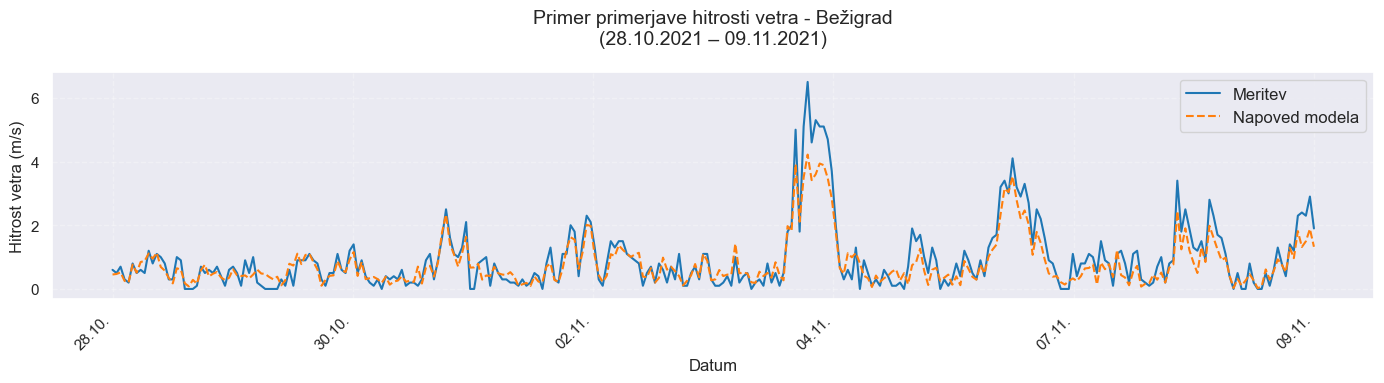

In [18]:
plot_week_comparison_with_dates(df_2021)

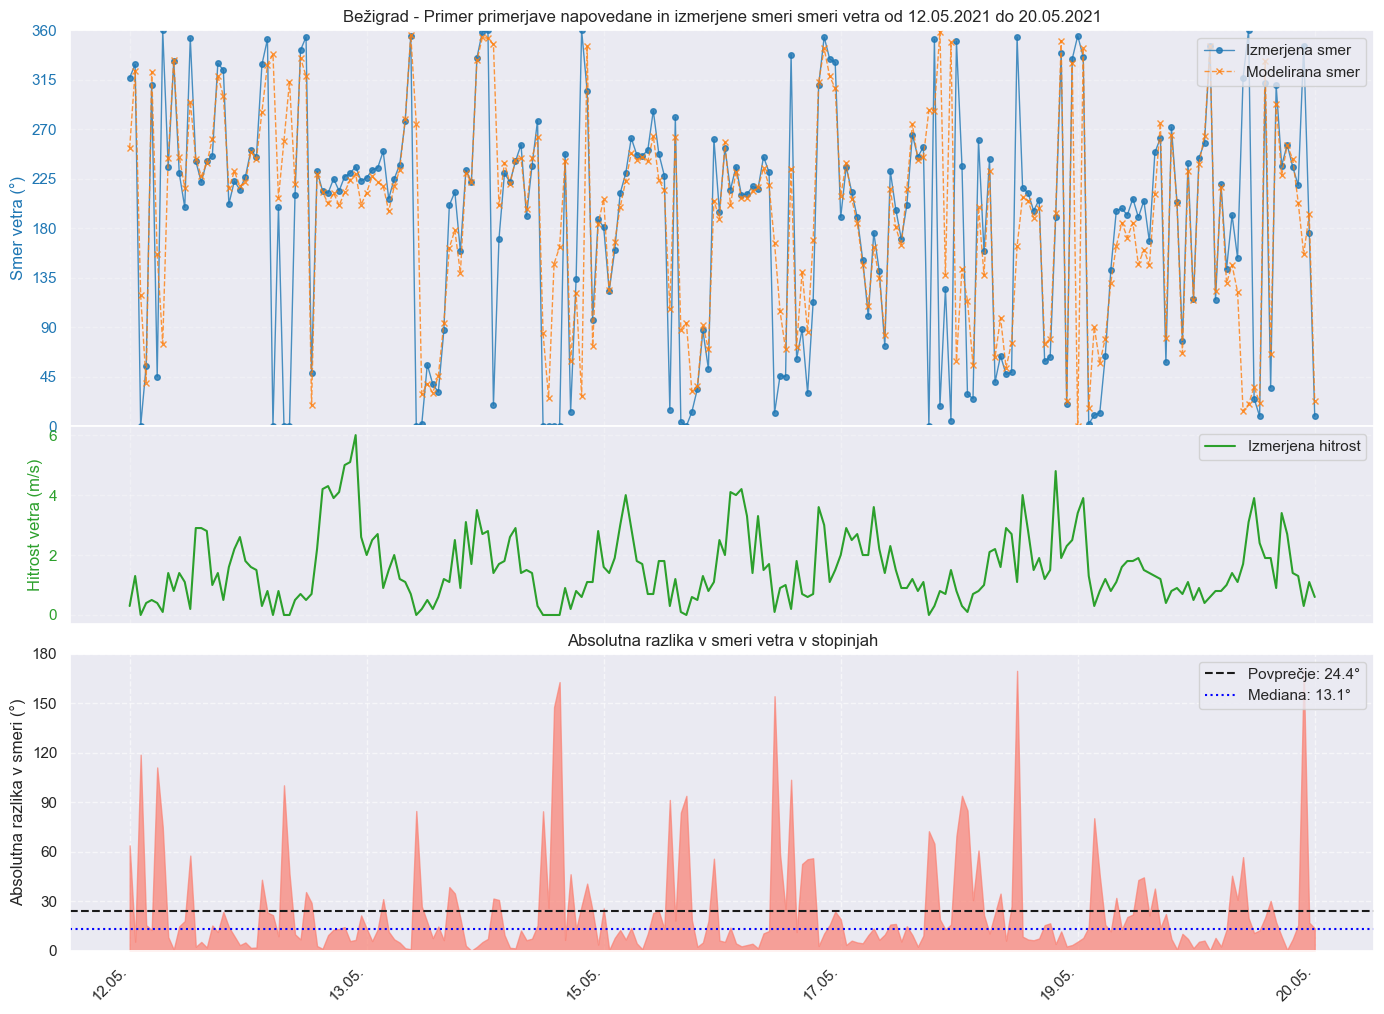

In [19]:
plot_wind_direction_comparison_bezigrad(df_2021, days=9)

<Figure size 1400x1500 with 0 Axes>

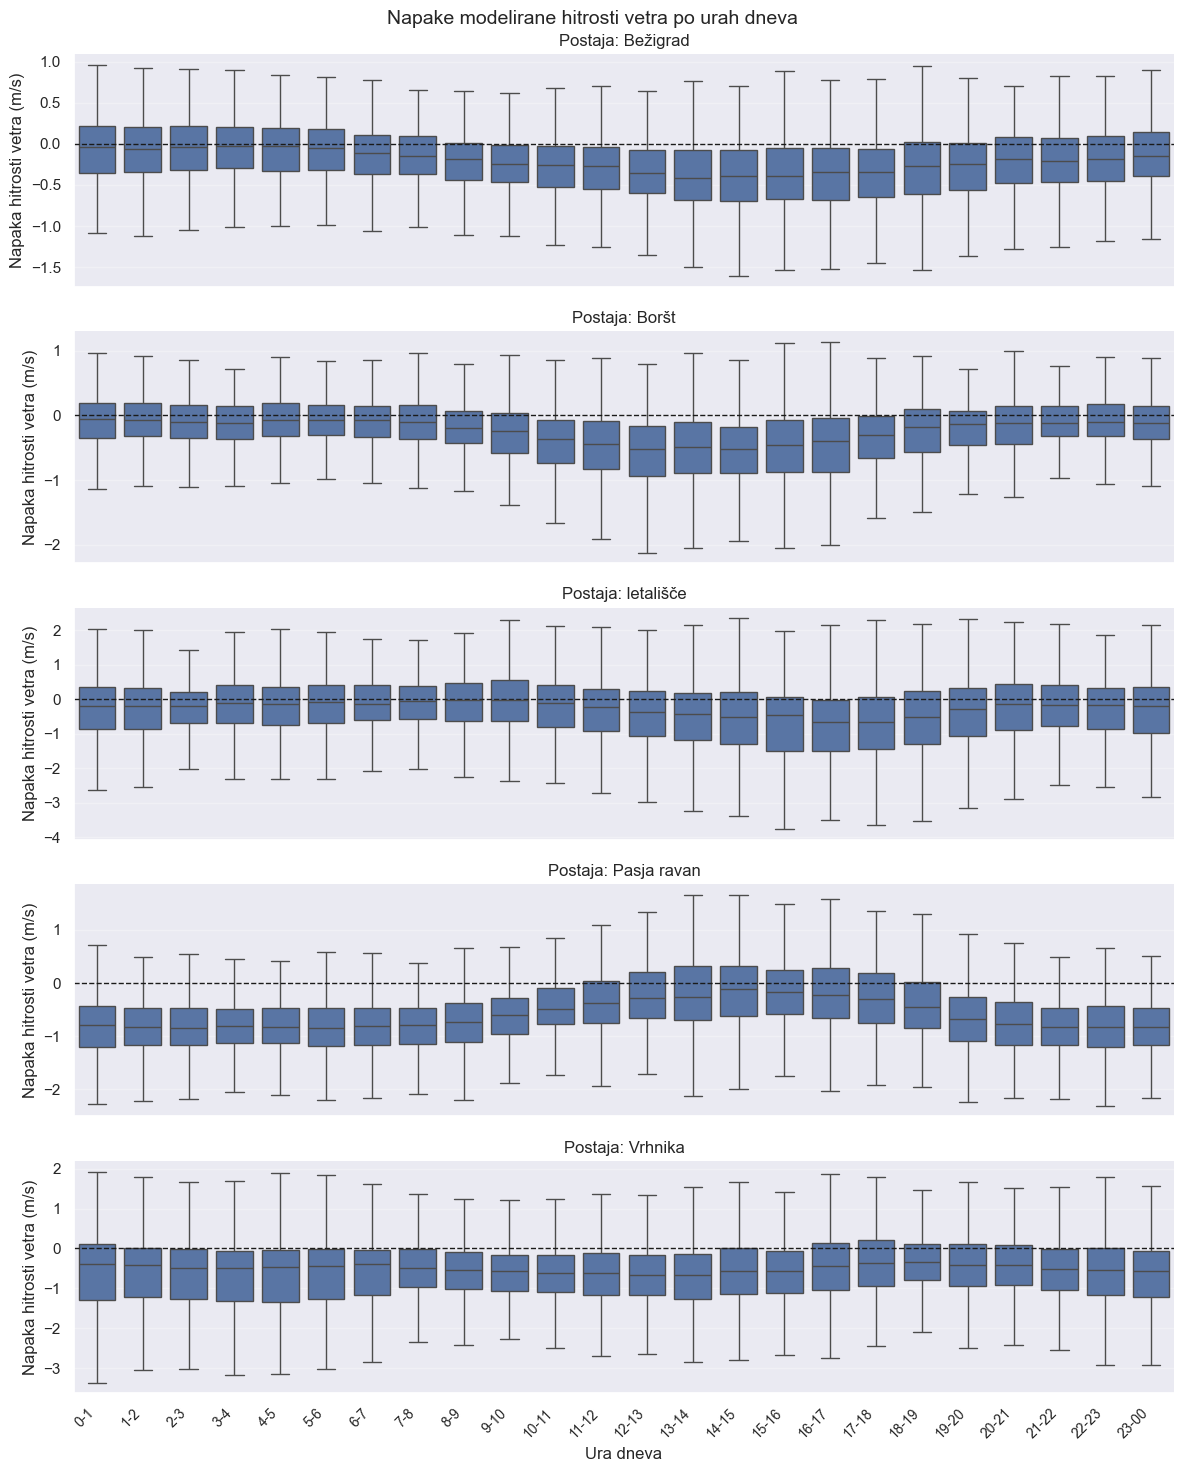

In [20]:
plot_wind_speed_error_by_hour_multistation(df_2021, [s for s in stations], names=names, stations_per_plot=5)

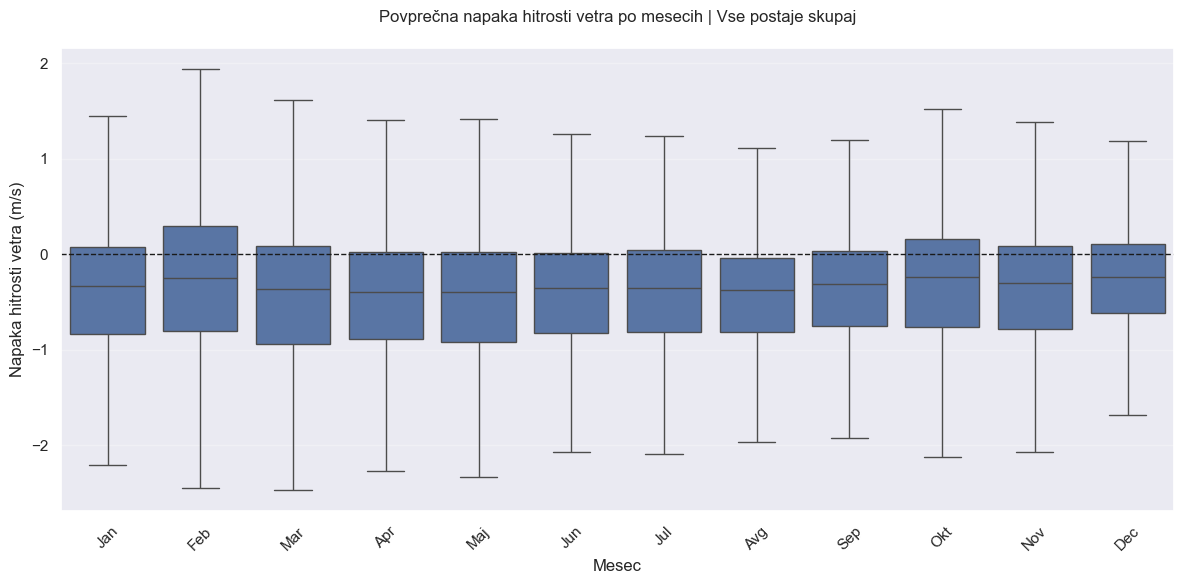

In [21]:
plot_wind_speed_error_by_month_all_stations(df_2021, [s for s in stations], names)

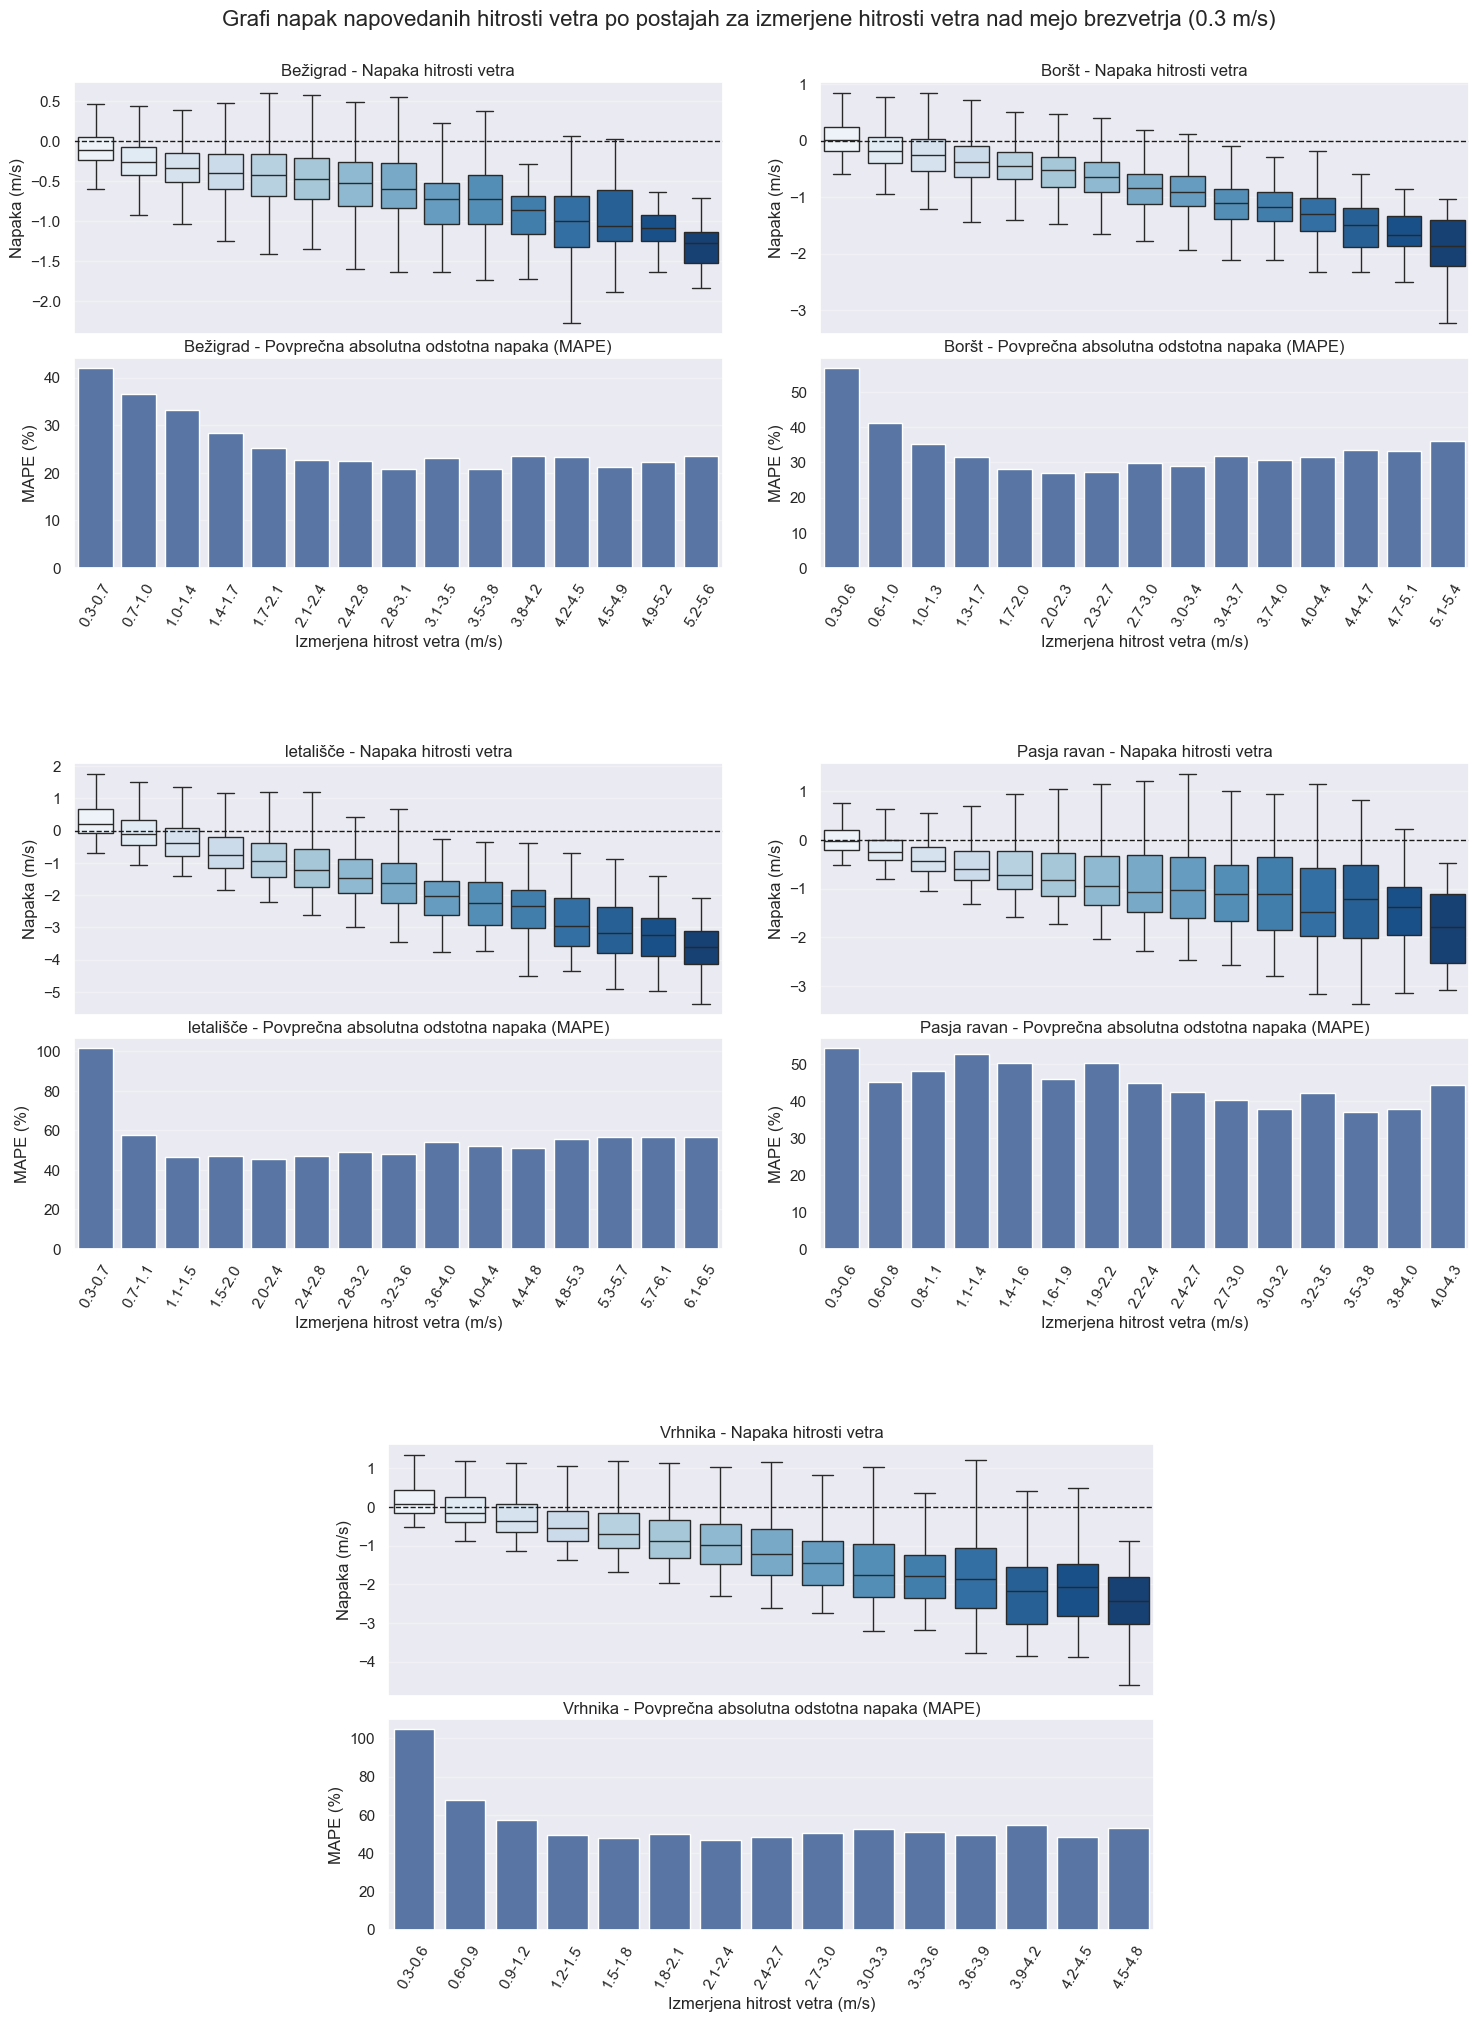

In [22]:
plot_wind_errors_all_stations(df=df_2021, stations=[s for s in stations], names=names, num_bins=15, min_wspeed=0.3)

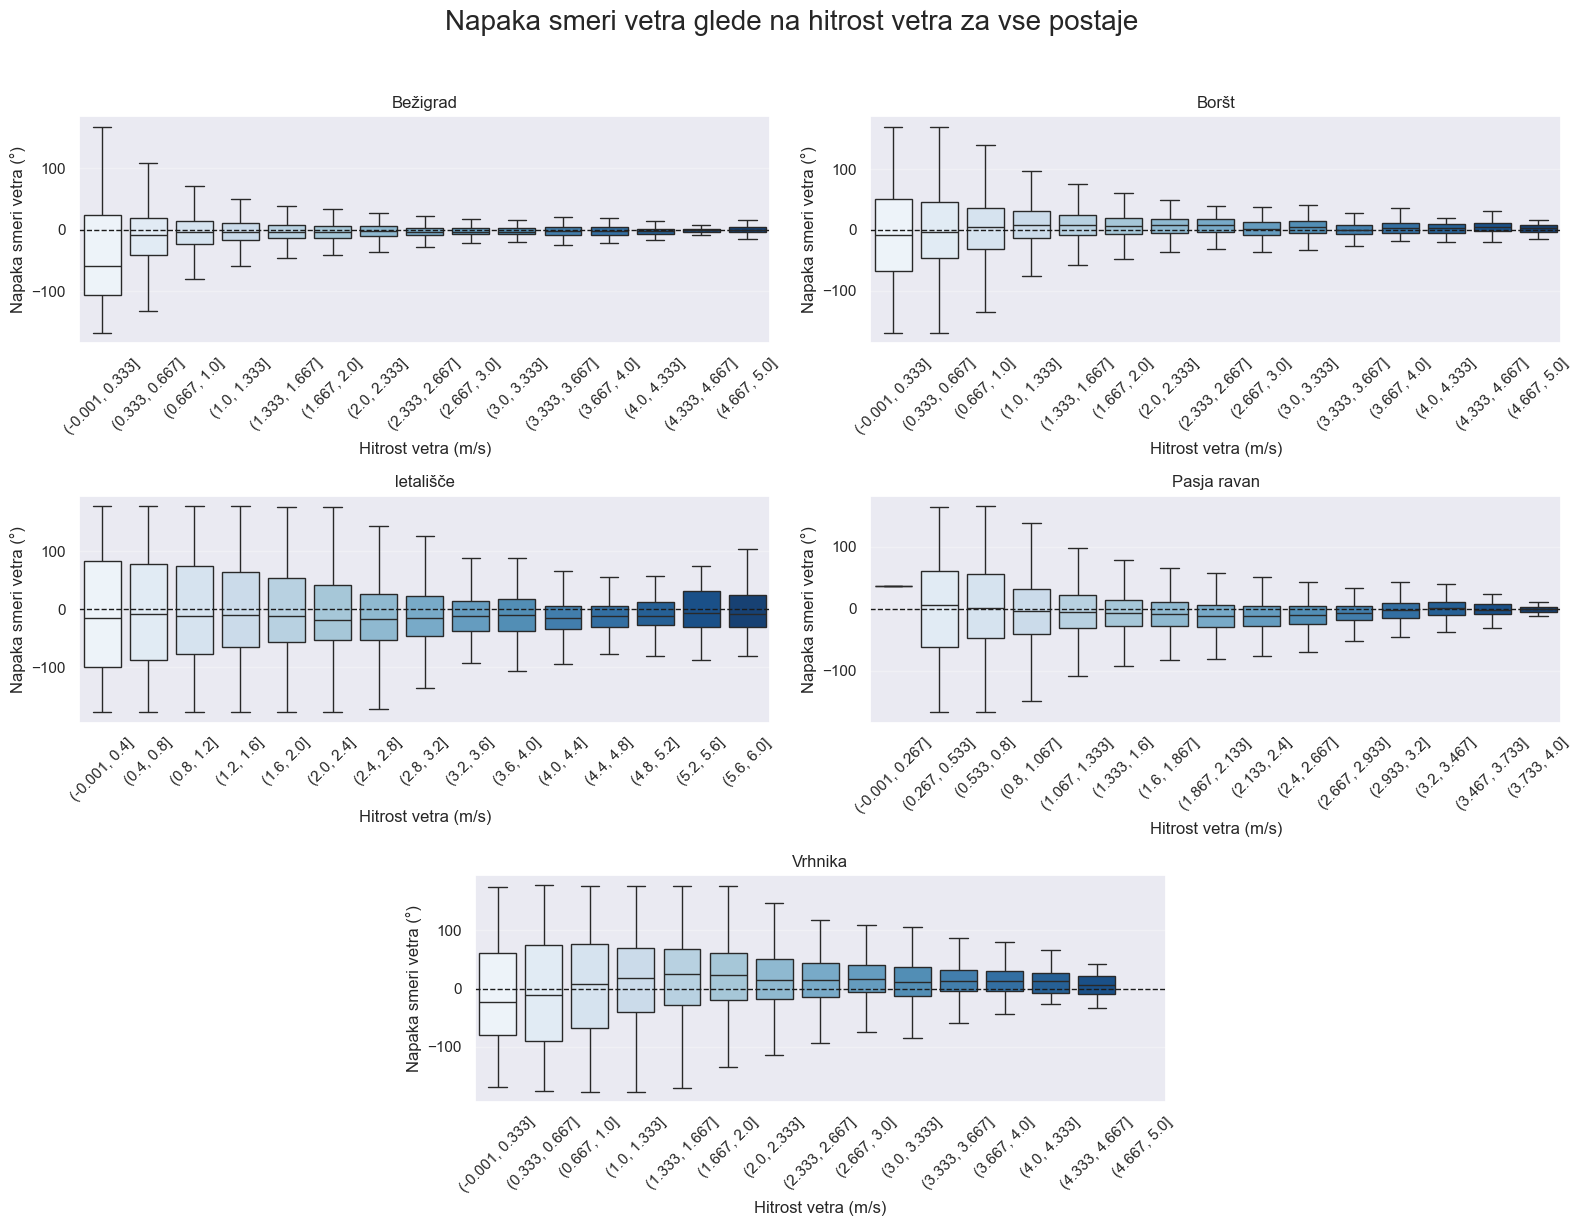

In [23]:
plot_wdir_error_by_wspeed_all_stations(df_2021, stations, num_bins=15, names=names)